In [36]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import imp
import pymaster as nmt
import utils
import pysm
from pysm.nominal import models
from pysm.common import convert_units
import seaborn as sns

%matplotlib inline

In [3]:
import h5py
import logLikeli
from logLikeli import logLike
from BP_beam import BPE as BPE

In [4]:
import time

In [5]:
from Fg_template import sync_ps as sync_ps_v0
from Fg_template import dust_ps as dust_ps_v0
from Fg_template import corre_fore_simple

In [6]:
from multiprocessing import Pool, cpu_count

In [7]:
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc 

from iminuit import Minuit

In [8]:
from pathos.multiprocessing import ProcessingPool as Pool
# from pathos.helpers import cpu_count

## Parameters

In [276]:
nside = 1024; 
bin_w =20;
nmtlmax = lmax = 1000;
beams = [19, 11]
SamNum = 50; 
Nf = 2; nf_ind = 3
fres = ['95','150'];

In [117]:
b = nmt.NmtBin(nside, nlb=bin_w, lmax=lmax, is_Dell = True)

lbin = len(b.get_effective_ells())

In [ ]:
lensingB = utils.Gencl(r = 0, raw_cl = True) ## only lensing BB; TT EE BB TE

bb_05 = utils.Gencl(r = 0.05, raw_cl = True, tensorBB_only=True) ##only tensor BB; ## 

def combine_ps(r):
    
    '''
    Combine the tensor bb and lensing bb power spectrum of CMB.
    '''
    
    bb_tensor = bb_05[0:nmtlmax+1]*r/0.05 

    bb_camb = bb_tensor #+ lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

    cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower, use simple window function
    cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
    for ell in range(lbin):
        cl_th_test[ell] *= cl_th_i[ell]
        
    return cl_th_test

In [12]:
rotate = hp.rotator.Rotator(coord=['G','C'])
# rotate.rotate_map_pixel(nvar_95_new)

## Function

In [119]:
mask = hp.ud_grade(hp.read_map('/fnx/jianyao/DataChallenge/AncillaryData/AliCPTWhiteNoiseMatrix/BINARYMASK_95_C_1024.fits', field=None, verbose = False), nside_out=nside)
hit = hp.ud_grade(hp.read_map('/fnx/jianyao/DataChallenge/AliCPT/HITMAP.fits',dtype=np.int,verbose=0), nside_out=nside);

extra_ratio = 0.3
extra = hit>0  # extra mask
mask[hit<extra_ratio*max(hit)] = 0
extra[hit>extra_ratio*max(hit)] = 0

mask_apo = nmt.mask_apodization(mask, 6, apotype='C2')

In [120]:
est_b = BPE(mask, nside=nside, bin_w = bin_w, lmax = lmax, beams=[19,11])

## Data

### foreground template

#### PySM

In [267]:
sky_config = {'dust' : models("d1", nside), 'synchrotron' : models("s1", nside)}
sky = pysm.Sky(sky_config);

In [273]:
## foreground for 95 and 150 GHz
nu = np.array((95, 150))
fore_maps = sky.signal()(nu)

In [32]:
cmb_map_i = np.load('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%n)
hp.smoothing((cmb_map_i), fwhm = 19/60/180*np.pi, lmax = 500, verbose = False)

array([[ 21.86027491,   7.00333503,  18.1144786 , ..., -45.76395099,
        -35.92624026, -41.22426094],
       [  0.17243014,  -0.07835693,  -0.31143937, ...,   0.16921364,
          0.66789917,  -0.72372328],
       [  2.70344409,  -2.29027065,   2.10863664, ...,   1.92258347,
         -1.49781116,   2.12111534]])

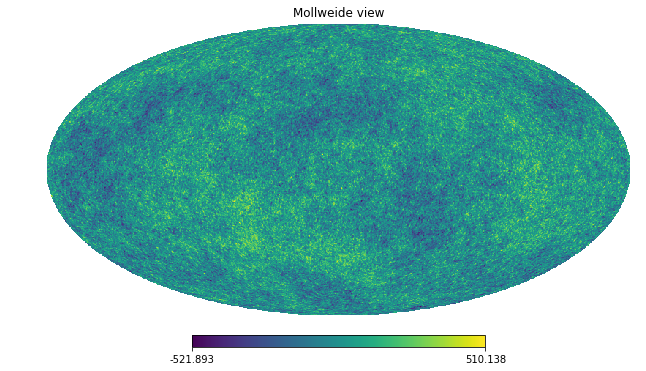

In [31]:
hp.mollview(cmb_map_i[0])

In [35]:
np.array([1,2])

array([1, 2])

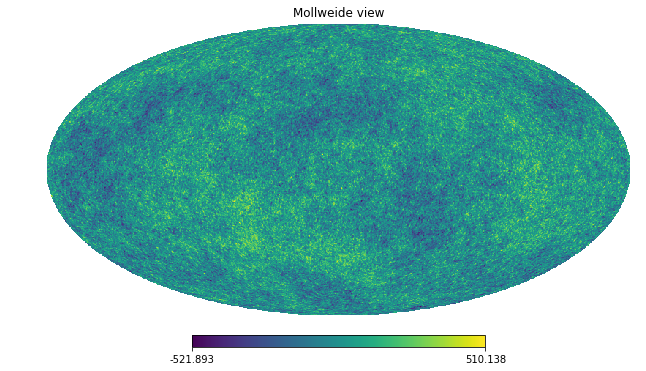

In [33]:
hp.mollview(cmb_map_i[0])

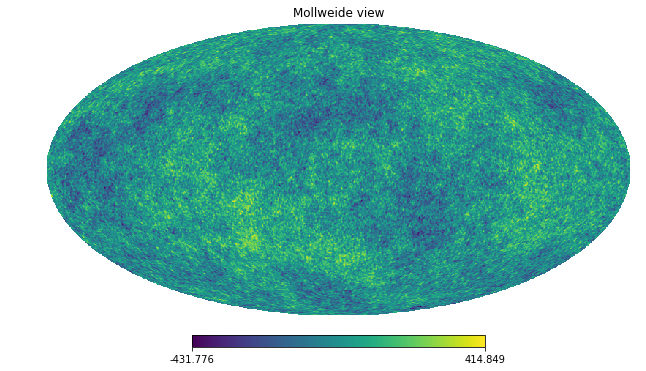

In [27]:
hp.mollview(cmb_map[0])

In [280]:
n = 0;  total_sim = np.zeros((Nf, 2, 12*nside**2))
cmb_map_i = np.load('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%n)
for fre in range(Nf):

    cmb_map = hp.smoothing(rotate.rotate_map_pixel(cmb_map_i), fwhm = beams[fre]/60/180*np.pi, lmax = lmax, verbose = False)
    nQU = np.load('/fnx/jianyao/DataChallenge/My_simulation/Noise/%sGHz/Noise_%sGHz_%03d.npy'%(fres[fre], fres[fre], n))  # QU only

    fore_maps[fre] = hp.smoothing(rotate.rotate_map_pixel(fore_maps[fre]), fwhm = beams[fre]/60/180*np.pi, lmax = lmax, verbose = False)

    total_sim[fre] = cmb_map[1:] + nQU + fore_maps[fre][1:] ## QU only

In [297]:
cl_hat_sim = est_b.Cross_EB(total_sim*mask)

In [285]:
### without beam ??? foreground template
s30_RJ = sky.synchrotron(30)

s30_RJ = rotate.rotate_map_pixel(s30_RJ);
f2_s = nmt.NmtField(mask_apo, s30_RJ[1:3], purify_e=False, purify_b=True)
A_s_RJ = nmt.compute_full_master(f2_s, f2_s, b)[3]

d353_RJ = sky.dust(353); d353_RJ = rotate.rotate_map_pixel(d353_RJ);
f2_d = nmt.NmtField(mask_apo, d353_RJ[1:3], purify_e=False, purify_b=True)
A_d_RJ = nmt.compute_full_master(f2_d, f2_d, b)[3]

# np.save('/fnx/jianyao/DataChallenge/dust_template_353_BB_RJ.npy', A_d_RJ)
# np.save('/fnx/jianyao/DataChallenge/sync_template_30_BB_RJ.npy', A_s_RJ)

#### WMAP-K and HFI-353GHz

In [121]:
# 353GHz: 4.944 arc-min
Map_353 = hp.ud_grade(hp.read_map('/fnx/jianyao/DataChallenge/SimulatedData/HFI_detector_F353/IQU_BOTH_HFI_detector_F353.fits', field = None, verbose = False)*1e6, nside_out= nside);
# K-band: 52.8
Map_k = hp.ud_grade(hp.read_map('/fnx/jianyao/DataChallenge/SimulatedData/WMAP_K/IQU_BOTH_WMAP_K.fits', field = None, verbose = False)*1e3, nside_out=nside)

In [122]:
bl_k = hp.gauss_beam(52.8/60/180*np.pi, lmax = 3*nside-1)
f2_K = nmt.NmtField(mask_apo, Map_k[1:3]*mask, purify_e=False, purify_b=True, beam=bl_k)
A_s = nmt.compute_full_master(f2_K, f2_K, b)[3]

bl_h = hp.gauss_beam(4.944/60/180*np.pi, lmax = 3*nside-1)
f2_h = nmt.NmtField(mask_apo, Map_353[1:3]*mask, purify_e=False, purify_b=True, beam=bl_h)
A_d = nmt.compute_full_master(f2_h, f2_h, b)[3]

In [123]:
A_d_tem = convert_units('uK_CMB', 'uK_RJ', 353)**2*A_d
A_s_tem = convert_units('uK_CMB', 'uK_RJ', 22)**2*A_s

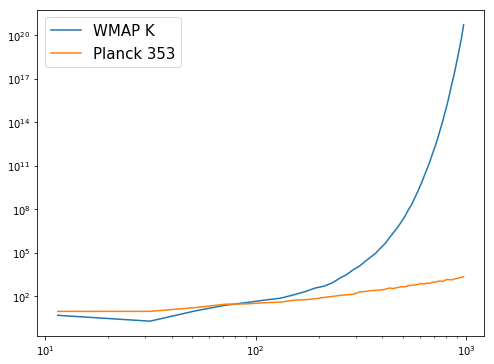

In [124]:
plt.figure(figsize = (8,6))
plt.loglog(est_b.ell_n, A_s, label = 'WMAP K', )
plt.loglog(est_b.ell_n, A_d, label = 'Planck 353')

# plt.loglog(est_b.ell_n, A_s_RJ, label = 'PySM sync 30')
# plt.loglog(est_b.ell_n, A_d_RJ, label = 'PySM dust 353')
# plt.xlim(50, 500); plt.ylim(10, 1e7)
plt.legend(fontsize = (15))
# plt.xlim(10,201)
# plt.ylim(1e-1,10)


### Ali data

In [177]:
Map_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/DataChallenge/AliCPT/IQU_BOTH_95_0.fits', field = None, verbose = False), nside_out=128)
Map_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/DataChallenge/AliCPT/IQU_BOTH_150_0.fits', field = None, verbose = False), nside_out=128)

total_map =np.array((Map_95[1:], Map_150[1:]))

In [37]:
var95 = h5py.File('/fnx/jianyao/DataChallenge/AncillaryData/AliCPTWhiteNoiseMatrix/NOISEVAR_95_0.h5', 'r')

## sigmaT, sigmaP, nhit
var150 = h5py.File('/fnx/jianyao/DataChallenge/AncillaryData/AliCPTWhiteNoiseMatrix/NOISEVAR_150_0.h5', 'r')

In [46]:
Nvar = np.array((var95['noise_map'][1], var150['noise_map'][1]))
## 95GHz sigmaP; 150GHz sigmaP

for i in range(2):
    Nvar[i] = rotate_i.rotate_map_pixel(Nvar[i])

In [41]:
rotate_i = hp.rotator.Rotator(coord=['C','G'])

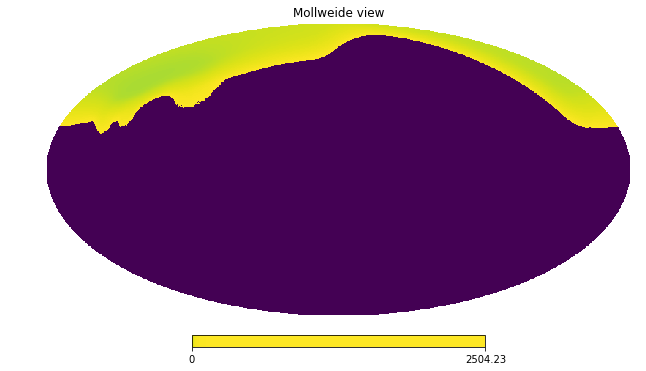

In [48]:
hp.mollview((Nvar[1]), norm = 'hist')

In [66]:
cl_r = utils.Gencl(0.05, raw_cl=True)

In [34]:
cl_hat_all_ali = est_b.Cross_EB(total_map*mask)

# np.save('/fnx/jianyao/DataChallenge/cl_hat_ali.npy', cl_hat_all_ali)

### Healpy PS

In [332]:
ell = np.arange(cl.shape[1])
cl = hp.anafast(Map_95[0]*mask)

Text(0, 0.5, '$D_\\ell$')

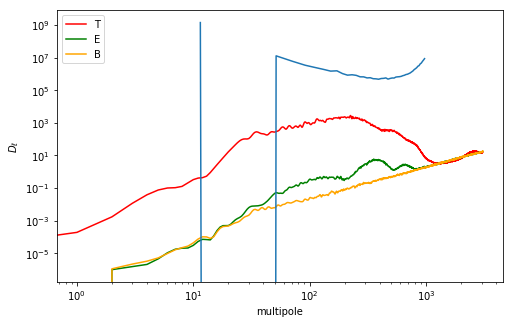

In [336]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(ell,ell*(ell+1)*cl[0],color='red',label='T')
ax.plot(ell,ell*(ell+1)*cl[1],color='green',label='E')
ax.plot(ell,ell*(ell+1)*cl[2],color='orange',label='B')

ax.loglog(est_b.ell_n, cl_hat_all_ali[2][:,0,0])

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel('multipole')
ax.set_ylabel(r'$D_\ell$')

### Namaster PS

#### Direct calculation

In [19]:
leff = b.get_effective_ells()

In [137]:
map0 = np.ones((2, 12*nside**2))
m0 = nmt.NmtField(mask_apo, map0, purify_e=False, purify_b=True, beam=hp.gauss_beam(19.0/60/180*np.pi, lmax = 3*nside - 1))  ##, beam=bl

w = nmt.NmtWorkspace()
w.compute_coupling_matrix(m0, m0, b)

In [131]:
def compute_master(f_a, f_b, wsp):
    cl_coupled = nmt.compute_coupled_cell(f_a, f_b)
    cl_decoupled = wsp.decouple_cell(cl_coupled)
    return cl_decoupled

In [138]:
cl_wps_wo_beam = compute_master(f2,f2, w)

In [142]:
f21 = nmt.NmtField(mask_apo, (Map_95*mask)[1:], purify_e=False, purify_b=True, beam=hp.gauss_beam(19.0/60/180*np.pi, lmax = 3*nside - 1))
f22 = nmt.NmtField(mask_apo, (Map_150*mask)[1:], purify_e=False, purify_b=True, beam=hp.gauss_beam(11.0/60/180*np.pi, lmax = 3*nside - 1))


cl_na = nmt.compute_full_master(f21, f22, b);

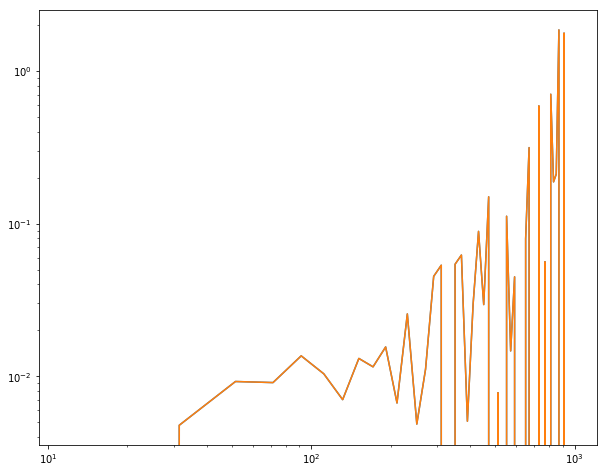

In [143]:
plt.figure(figsize = (10, 8));
plt.loglog(leff, cl_na[3])
# plt.loglog(leff, cl_wps_wo_beam[3])

plt.loglog(leff, cl_hat_all_ali[2][:,0,1])

#### Simulation of CMB and Noise; Also simulate the observed data with nside = 1024

In [49]:
fres = ['95','150']; nside = 1024
Nf = len(fres)
for n in range(50):
    
#     cmb_map_i = hp.synfast(cl_r, nside = nside, new = True, verbose = False)
    
#     np.save('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%n, cmb_map_i)
    
    for fre in range(Nf):

        var = Nvar[fre]

        nQU = np.zeros((2, 12*nside**2))
        nQU[0] = np.random.normal(0, var)
        nQU[1] = np.random.normal(0, var)
        
        np.save('/fnx/jianyao/DataChallenge/My_simulation/Noise/Galactic/%sGHz/Noise_%sGHz_%03d.npy'%(fres[fre], fres[fre], n), nQU)

In [ ]:
#     cmb_map_i = hp.synfast(cl_r, nside = nside, new = True, verbose = False)
    
#     np.save('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%n, cmb_map_i)

In [423]:
leff = b.get_effective_ells()

/home/jianyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


Text(0.5, 1.0, 'One of noise realization')

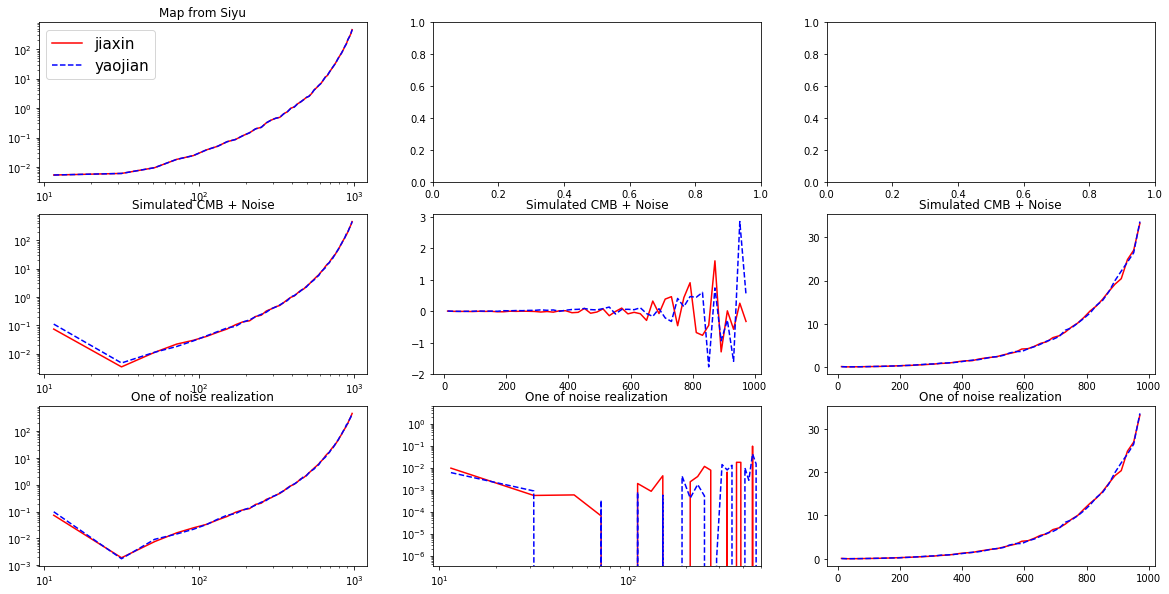

In [451]:
jx_data = np.load('/fnx/jianyao/DataChallenge/abs_alicpt_inter_1024.npy', allow_pickle=True)

fig, axes = plt.subplots(3,3, figsize = (20, 10))
# plt.loglog(est_b.ell_n, )
axes[0][0].loglog(leff, jx_data[0][0][:,0,0],'r', label = 'jiaxin')

axes[0][0].loglog(leff, cl_hat_ali[2][:,0,0], 'b--', label = 'yaojian')
axes[0][0].set_title('Map from Siyu')
axes[0][0].legend(fontsize = 15)

axes[1][0].loglog(leff, jx_data[0][1][:,0,0], 'r', label = 'jx')
axes[1][0].loglog(leff, cl_f_all[0][2][:,0,0], 'b--',label = 'jy')
axes[1][0].set_title('Simulated CMB + Noise')

axes[1][1].plot(leff, jx_data[0][1][:,0,1], 'r', label = 'jx')
axes[1][1].plot(leff, cl_f_all[0][2][:,0,1], 'b--',label = 'jy')
axes[1][1].set_title('Simulated CMB + Noise')

axes[1][2].plot(leff, jx_data[0][1][:,1,1], 'r', label = 'jx')
axes[1][2].plot(leff, cl_f_all[0][2][:,1,1], 'b--',label = 'jy')
axes[1][2].set_title('Simulated CMB + Noise')

axes[2][0].loglog(leff, jx_data[1][1][:,0,0], 'r', label = 'jx')
axes[2][0].loglog(leff, nl_all[0][2][:,0,0], 'b--',label = 'yj')
axes[2][0].set_title('One of noise realization')

axes[2][1].plot(leff, jx_data[1][1][:,0,1], 'r', label = 'jx')
axes[2][1].loglog(leff, nl_all[0][2][:,0,1], 'b--',label = 'yj')
axes[2][1].set_title('One of noise realization')
axes[2][1].set_xlim(0,500)

axes[2][2].plot(leff, jx_data[1][1][:,1,1], 'r', label = 'jx')
axes[2][2].plot(leff, nl_all[0][2][:,1,1], 'b--',label = 'yj')
axes[2][2].set_title('One of noise realization')

#### Cross PS

In [190]:
# # %%time 
# index = np.arange(len(mask))#index[n2zeros == 0]
# ali_pix = index[mask != 0]

fres = ['95','150']
cpn = np.zeros((Nf, 2, 12*nside**2)); ## CMB plus noise
cl_f_all = np.ones((SamNum, 3, lbin, Nf, Nf))
nl_all = np.zeros((SamNum, 3, lbin, Nf, Nf))
Noise = np.zeros((Nf, 2, 12*nside**2))

for n in range(SamNum):
    start = time.time()
    cmb_map_i = hp.ud_grade(np.load('/fnx/jianyao/DataChallenge/My_simulation/CMB/cmb_maps_mc_%03d.npy'%n), nside_out=128)
    
    for fre in range(Nf):

        cmb_map = hp.smoothing(rotate.rotate_map_pixel(cmb_map_i), fwhm = beams[fre]/60/180*np.pi, lmax = lmax, verbose = False)
        nQU = hp.ud_grade(np.load('/fnx/jianyao/DataChallenge/My_simulation/Noise/%sGHz/Noise_%sGHz_%03d.npy'%(fres[fre], fres[fre], n)), nside_out=128)  # QU only
        cpn[fre] = (cmb_map)[1:]  + nQU
        Noise[fre] = nQU
        
    nl_all[n] = est_b.Cross_EB(Noise*mask)
    cl_f_all[n] = est_b.Cross_EB(cpn*mask)
    end = time.time()
    print(n)
    print('time', (end - start)/60.0)
#         np.save('/fnx/jianyao/Likelihood_data/Simulations/Noises_Ali_2fre/%sGHz/Noise_realizations_%sGHz_%03d.npy'%(fres[fre], fres[fre], n), nIQU) ## (SamNum,3, npix) , (nIQU.swapaxes(1,2).swapaxes(0,1))

0
time 0.08795456886291504
1
time 0.09641085465749105
2
time 0.08423309326171875
3
time 0.08420315186182657
4
time 0.08451668818791708
5
time 0.08944843212763469
6
time 0.0901236097017924
7
time 0.0870692531267802
8
time 0.08572200139363607
9
time 0.08740546703338622
32
time 0.08977984587351481
33
time 0.08890480200449626
34
time 0.08660531838734944
35
time 0.08603483041127523
36
time 0.08908981084823608
37
time 0.08703882296880086
38
time 0.08720908959706625
39
time 0.08642626206080119
40
time 0.08591558535893758
41
time 0.08566012779871622
42
time 0.0858437180519104
43
time 0.08573326667149862
44
time 0.0875343362490336
45
time 0.08890995184580484
46
time 0.08724114894866944
47
time 0.08660581509272257
48
time 0.08776917457580566
49
time 0.08644797801971435


In [194]:
cl_hat_all_ali = est_b.Cross_EB(total_map*mask)

np.save('/fnx/jianyao/DataChallenge/cl_hat_ali_nside_128.npy', cl_hat_all_ali)

In [195]:
np.save('/fnx/jianyao/DataChallenge/cl_f_all_nside_128.npy', cl_f_all)
np.save('/fnx/jianyao/DataChallenge/nl_all_nside_128.npy', nl_all)

## Analysis

### check simulated noise and CMB

In [186]:
noise_siyu_95 = hp.read_map('/fnx/jianyao/DataChallenge/AncillaryData/AliCPTNoiseSimulations/0/IQU_BOTH_95_0.fits', field = None)

noise_siyu_95_wo = hp.read_map('/fnx/jianyao/DataChallenge/AncillaryData/AliCPTNoiseSimulations/0/IQU_WOFILTER_95_0.fits', field = None)

noise_siyu_150 = hp.read_map('/fnx/jianyao/DataChallenge/AncillaryData/AliCPTNoiseSimulations/0/IQU_BOTH_150_0.fits', field = None)

noise_siyu_150_wo = hp.read_map('/fnx/jianyao/DataChallenge/AncillaryData/AliCPTNoiseSimulations/0/IQU_WOFILTER_150_0.fits', field = None)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [128]:
noise_my = np.row_stack((nIQU[0], nIQU))

In [132]:
nl_hp = hp.anafast(noise_my*mask);
# nl_siyu = hp.anafast(nosie_siyu*mask)

In [192]:
nl_na_wo = est_b.Cross_EB([noise_siyu_95_wo[1:]*mask,noise_siyu_150_wo[1:]*mask])
nl_na = est_b.Cross_EB([noise_siyu_95[1:]*mask,noise_siyu_150[1:]*mask])

In [86]:
camb_cl = utils.Gencl(0.05, raw_cl=False)

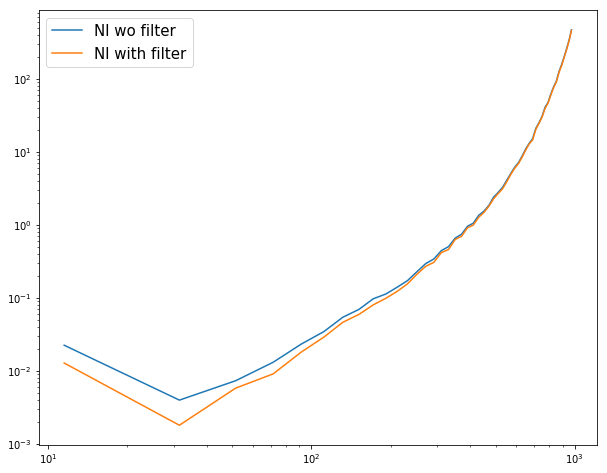

In [198]:
plt.figure(figsize = (10, 8))
plt.loglog(est_b.ell_n, nl_na_wo[2][:,0,0], label = 'Nl wo filter')
plt.loglog(est_b.ell_n, nl_na[2][:,0,0], label = 'Nl with filter')

plt.legend(fontsize = 15)

(0.001, 1)

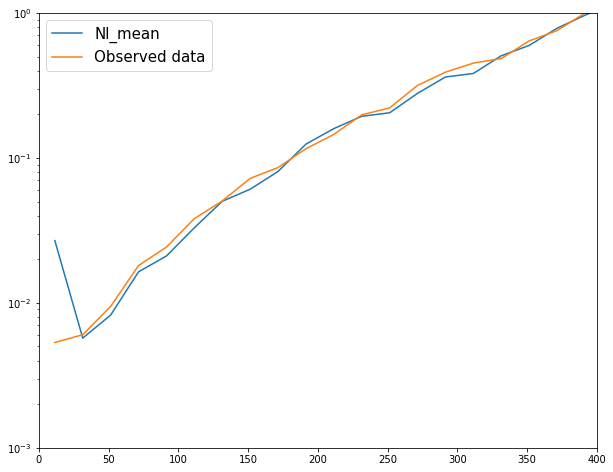

In [106]:
plt.figure(figsize = (10, 8))
# plt.loglog(est_b.ell_n, cl_f_all[0][2][:,0,0], label = 'cl_f')
plt.plot(est_b.ell_n, nl_all[19][2][:,0,0], label = 'Nl_mean')
# plt.loglog(est_b.ell_n, nl_all[19][2][:,0,0] + dust_ps_v0(A_d_RJ, beta_d, lbin)[:,0,0] + sync_ps_v0(A_s_RJ, beta_s, lbin)[:,0,0], label = 'Nl_mean + fore')

# plt.loglog(est_b.ell_n, nl_all[19][0][:,0,0], label = 'Nl_mean')

# beta_d = 1.59; beta_s = -3.0
# plt.plot(est_b.ell_n, dust_ps_v0(A_d_RJ, beta_d, lbin)[:,0,0])
# plt.plot(est_b.ell_n, sync_ps_v0(A_s_RJ, beta_s, lbin)[:,0,0])

# # els = np.arange(len(nl_hp[0]))
# # el2 = utils.l2(els)
# plt.loglog(els, el2*nl_hp[2]/0.09)
# # plt.loglog(els, el2*nl_siyu[2]/0.09)

plt.plot(est_b.ell_n,cl_hat_ali[2][:,0,0], label = 'Observed data')
plt.legend(fontsize = 15)
plt.yscale('log')
plt.xlim(0, 400)
plt.ylim(1e-3,1)
# plt.loglog(np.arange(len(camb_cl[2])), camb_cl[1])

### likelihood analysis

In [258]:
cl_hat_ali = np.load('/fnx/jianyao/DataChallenge/cl_hat_ali.npy')

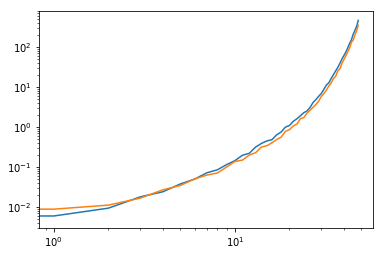

In [298]:
plt.loglog(cl_hat_ali[2,:,0,0])
plt.loglog(cl_hat_sim[2,:,0,0])

In [250]:
cl_f_all = np.load('/fnx/jianyao/DataChallenge/cl_f_all.npy'); 
nl_all = np.load('/fnx/jianyao/DataChallenge/nl_all.npy')
nl_mean = np.mean(nl_all, axis = 0) ## EE EB BB

# jx_data = np.load('/fnx/jianyao/DataChallenge/abs_alicpt_inter_1024.npy', allow_pickle=True);

# cl_hat_ali = jx_data[0][0];
# nl_all = jx_data[1][1:];

# nl_mean = np.mean(nl_all, axis = 0) ## EE EB BB

# cl_f_all = np.zeros((9, 3, 49, 2, 2))

# for i in range(9):
#     cl_f_all[i,2] = jx_data[0][i + 1]

In [399]:
path = '/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise'
cl_f_all_ali = np.load('%s/cl_f_all.npy'%path); cl_f_ali = np.mean(cl_f_all_ali, axis = 0)
cl_hat_all_ali = np.load('%s/cl_hat_fore_all.npy'%path) 

nl_all_ali = np.load('%s/nl_all.npy'%path)
nl_mean_ali = np.mean(nl_all_ali, axis = 0) ## EE EB BB

A_d_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_template_353_BB_RJ.npy')
A_s_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_template_30_BB_RJ.npy')

In [434]:
LogL = logLike(2,10) 

 ## calculate logL.cl_f; logL.Cov  
LogL.M(cl_f_all = cl_f_all_ali, SamNum=500, method = 'oas')

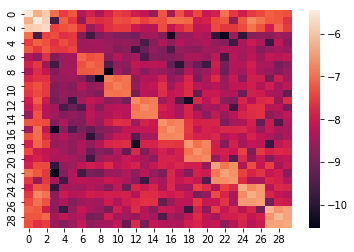

In [407]:
sns.heatmap(np.log10(abs(LogL.Cov)))

#### data comparision with Jiaxin

In [103]:
jx_data = np.load('/fnx/jianyao/DataChallenge/abs_alicpt_inter_1024.npy', allow_pickle=True);

cl_hat_ali = jx_data[0][0];
nl_all = jx_data[1][1:];

nl_mean = np.mean(nl_all, axis = 0) ## EE EB BB

cl_f_all = np.zeros((9, 3, 49, 2, 2))

for i in range(9):
    cl_f_all[i,2] = jx_data[0][i + 1]

In [91]:
Xall_vecp = np.zeros((9, 147)); Xall_vecp_jx = np.zeros((9, 147))
for i in range(9):
    Xall_vecp[i] = utils.calculate_vecp_ga(jx_data[0][1:][i], Nf = 2, vecp_f='vecp')
    Xall_vecp_jx[i] = utils.calculate_vecp_ga(jx_data[0][1:][i], Nf = 2, vecp_f='jx')

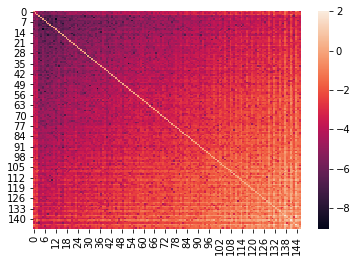

In [98]:
sns.heatmap((np.log10(abs(M_oas))))

In [112]:
M_oas = oas_est(Xall_vecp_jx)
M_cov = np.cov(Xall_vecp.T)

In [113]:
np.linalg.eigh(M_oas)[0]

array([  1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37178448,
         1.37178448,   1.37178448,   1.37178448,   1.37

#### run dynesty

In [429]:
beta_s = -3.0; beta_d = 1.6; epsilon = 0.4;
fl_hat = sync_ps_v0(A_s_RJ, beta_s, lbin) + dust_ps_v0(A_d_RJ, beta_d, lbin) + corre_fore_simple(epsilon, A_d_RJ, A_s_RJ, beta_s, beta_d, lbin)

def r_likelihood(r_i):
    cl_th_test = combine_ps(r_i)
    C_l = cl_th_test + nl_mean_ali[2] + fl_hat

    logl = LogL.run(cl_hat=(cl_hat_fore_ali) ,cl_th = C_l, likelihood='Gauss', sbin=sbin, ebin = ebin)
    
    return -2*logl

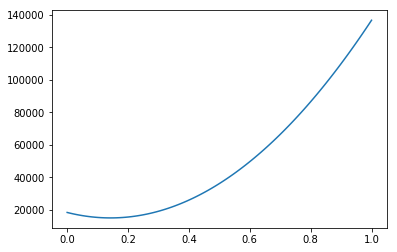

In [430]:
rlist = np.linspace(0, 1, 100);
logl = []
for i in range(len(rlist)):
    logl.append(r_likelihood(rlist[i]))
    
plt.plot(rlist, logl)

In [468]:
npara = 4; Nsim = 1; sbin = 1; ebin = 10#
lbin= len(A_s_RJ)

def prior(cube):
    
    r = cube[0]*0.2
    beta_s = cube[1]*4 - 5## from -4 to -2
#     beta_d = cube[2]*0.4 + 1.4 ## from 1.4 to 1.8
    beta_d = cube[2]*2 + 1 
    epsilon = cube[3];
    
    return [r, beta_s, beta_d, epsilon]

Mean = np.zeros((Nsim,npara)); Samples = np.zeros((Nsim, npara)); Weights = np.zeros(Nsim); Results = []
# LogL.Cov = LogL.Cov*10.0;

for n in range(0, Nsim):
    
    cl_hat_fore_ali = cl_hat_all_ali[1][2]
      
    def log_likelihood(cube, subtract = False):
        
        r_i = cube[0];
        beta_s = cube[1];
        beta_d = cube[2];
        epsilon = cube[3];

        cl_th_test = combine_ps(r_i)  ## combine the tensor bb and lensing bb
        
        fl_hat = sync_ps_v0(A_s_RJ, beta_s, lbin) + dust_ps_v0(A_d_RJ, beta_d, lbin) + corre_fore_simple(epsilon, A_d_RJ, A_s_RJ, beta_s, beta_d, lbin)
        
        # add Noise bias N_l to expectation values.########################## Noise level
        C_l = cl_th_test + nl_mean_ali[2] + fl_hat
        
        logL =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, likelihood='HL',sbin=sbin, ebin = ebin); 
#         print(logL)
#         print(np.linalg.det(LogL.Cov))
        return np.real(logL)
    
#     with Pool(cpu_count()-1) as executor:
        
    sampler = dynesty.NestedSampler(log_likelihood, prior, npara, nlive=400, pool=Pool(cpu_count()-1), queue_size=cpu_count(), bootstrap = 0)
    sampler.run_nested()
    results = sampler.results
    Results.append(results)
    
    if n == 0 : 
        samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    
    else: 
        _samples, _weights = results.samples, np.exp(results.logwt - results.logz[-1])
        samples = np.r_[samples, _samples];
        weights = np.r_[weights, _weights];
        
#     print(n)

5686it [00:21, 268.73it/s, +400 | bound: 23 | nc: 1 | ncall: 28083 | eff(%): 21.671 | loglstar:   -inf < -261.087 <    inf | logz: -274.333 +/-  0.252 | dlogz:  0.001 >  0.409]


In [396]:
best_fit = np.ones(4)
weights = np.atleast_1d(weights)
q = np.array((0.5))
q = np.atleast_1d(q)

for i in range(4):
    
    x = np.atleast_1d(samples[:,i])
    idx = np.argsort(x)  # sort samples
    sw = weights[idx]  # sort weights
    cdf = np.cumsum(sw)[:-1]  # compute CDF
    cdf /= cdf[-1]  # normalize CDF
    cdf = np.append(0, cdf)  # ensure proper span
    best_fit[i] = (np.interp(q, cdf, x[idx]).tolist())[0]

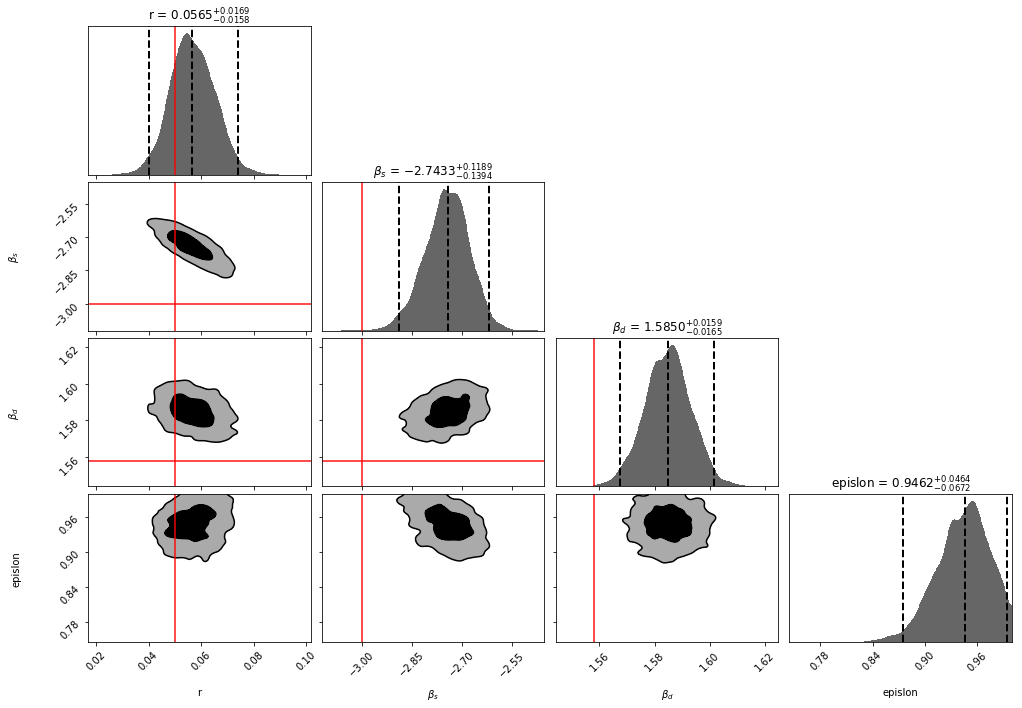

In [445]:
truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

In [344]:
# r_i = 0.0968; beta_s = -4.98; beta_d = 2.47; epsilon = 0.44;
# r_i = 0.0991; beta_s = -2.9819; beta_d = 2.0570; epsilon = 0.5054;
r_i, beta_s, beta_d, epsilon = dynesty.utils.mean_and_cov(samples, weights)[0]
fl_hat = sync_ps_v0(A_s_RJ, beta_s, lbin) + dust_ps_v0(A_d_RJ, beta_d, lbin) + corre_fore_simple(epsilon, A_d_RJ, A_s_RJ, beta_s, beta_d, lbin)

def r_likelihood(r_i):
    cl_th_test = combine_ps(r_i)
    C_l = cl_th_test + nl_mean[2] + fl_hat

    logl = LogL.run(cl_hat=(cl_hat_fore_ali) ,cl_th = C_l, likelihood='Gauss', sbin=sbin, ebin = ebin)
    
    return -2*logl, C_l

cl_recover = r_likelihood(r_i)[1]

In [347]:
beta_s

-2.991929893750245

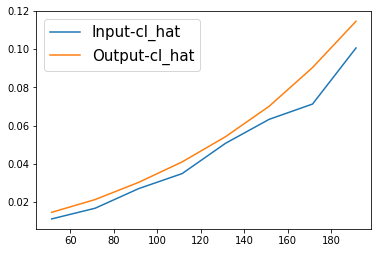

In [343]:
plt.plot(est_b.ell_n[sbin:ebin], cl_hat_sim[2,:,0,0][sbin:ebin], label = 'Input-cl_hat')
plt.plot(est_b.ell_n[sbin:ebin], cl_recover[:,0,0][sbin:ebin], label = 'Output-cl_hat')
plt.legend(fontsize = 15)

### using minuit

In [384]:
method = 'HL'; sbin = 2; ebin = 25;
def Min_log_likelihood(r_i, beta_s, beta_d, epsilon):
   
    fl_hat = sync_ps_v0(A_s_tem, beta_s, lbin) + dust_ps_v0(A_d_tem, beta_d, lbin) + corre_fore_simple(epsilon, A_d_tem, A_s_tem, beta_s, beta_d, lbin)

    C_l = combine_ps(r_i) + nl_mean[2] + fl_hat;
   
    if method == 'HL':
        logL_nu = utils.testL(cl_hat = cl_hat_ali[2], cl_f = LogL.cl_f[2], cl_th = C_l, Nf = Nf, M_inv = LogL.Cov_inv, sbin = sbin, ebin = ebin)
            
    elif method == 'Gauss':
        logL_nu = utils.simple_likelihood(cl_hat_ali[2], C_l, Nf = Nf, M_inv = LogL.Cov_inv, sbin = sbin, ebin = ebin)
            
    return -2*logL_nu

In [385]:
m = Minuit(Min_log_likelihood, r_i = 0.1, beta_s = -3, beta_d = 2.7, epsilon = 0.1,limit_r_i = (0,1), limit_beta_s = (-4,4), limit_beta_d = (1,3), limit_epsilon = (0,1), errordef = Minuit.LIKELIHOOD)

In [386]:
m.migrad()

/home/jianyao/Likelihood/utils.py:207: RuntimeWarning: invalid value encountered in log
  gd = np.sign(d - 1) * np.sqrt(2 * (d - np.log(d) - 1))
/home/jianyao/Likelihood/utils.py:207: RuntimeWarning: divide by zero encountered in log
  gd = np.sign(d - 1) * np.sqrt(2 * (d - np.log(d) - 1))
/home/jianyao/Likelihood/utils.py:215: ComplexWarning: Casting complex values to real discards the imaginary part
  Xall[l*nf_ind:(l+1)*nf_ind] = vecp_jx(X)


------------------------------------------------------------------
| FCN = 151.1                   |     Ncalls=112 (112 total)     |
| EDM = 2.74e-05 (Goal: 0.0001) |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
---------------------------------------------------------------------------------------------
|   | Name    |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
---------------------------------------------------------------------------------------------
| 0 | r_i     |    0.0    |    0.6    |            |            |    0    |    1    |       |
| 1 | beta_s  |  -4.000   |   0.007   |            |            |   -4    |    4    |       |
| 2 | beta_d  |    3.0    |    1.7    |            |            |    1    |    3    |       |
| 3 | epsilon |    1.0    |    0.9    |            |            |    0    |    1    |       |
---------------------------------------------------------------------------------------------